# Лабораторная 2. Распознавание изображений

In [5]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import torchvision
import torch.optim as optim
from torchvision import datasets
from torchvision.transforms import v2
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import CosineAnnealingLR

import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image

## Загрузка датасета

In [6]:
# Трансформации для нормализации CIFAR-100
transform_train = transforms.Compose([
    #transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomAffine(0, translate=(0.1, 0.1)),
    transforms.RandomCrop(32, padding=4, padding_mode="reflect"),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010]),  # Нормализация
])

transform_test = transforms.Compose([
    #transforms.Resize((128, 128)),    # Увеличиваем размер для тестовых изображений
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010]),  # Нормализация
])

# Загружаем CIFAR-100
trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_train)
train_loader = DataLoader(trainset, batch_size=32, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_test)
test_loader = DataLoader(testset, batch_size=32, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


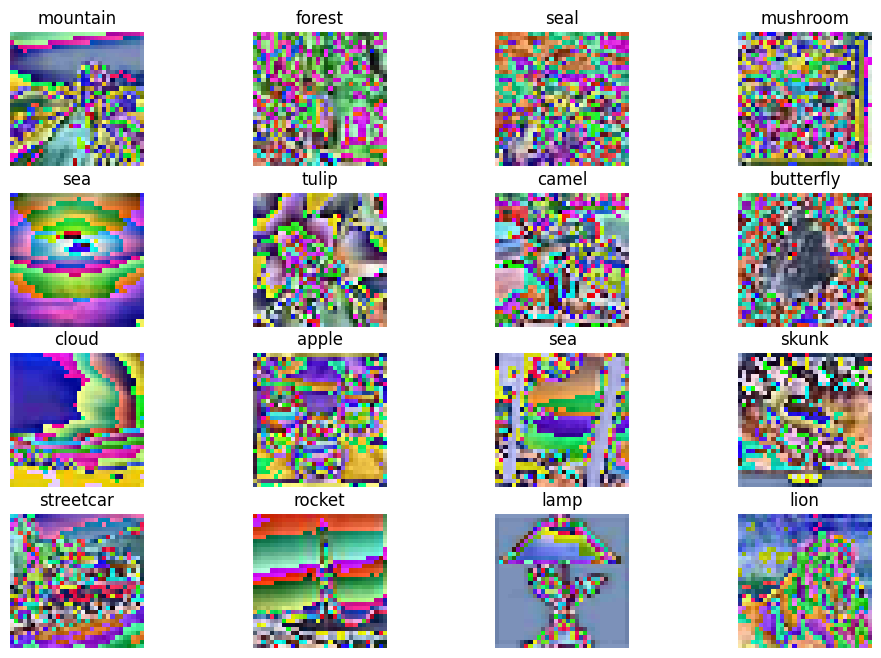

In [7]:
def show_images(images, labels, classes):
    plt.figure(figsize=(12, 8))
    for i in range(16):
        plt.subplot(4, 4, i + 1)
        image = to_pil_image(images[i])
        plt.imshow(image)
        actual_class = classes[labels[i]]
        plt.title(f"{actual_class}")
        plt.axis('off')
    plt.show()

for x, y in test_loader:
    show_images(x, y, testset.classes)
    break

# Модель

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BasicBlock(nn.Module):
    def __init__(self, in_planes, out_planes, stride=1, dropout_rate=0.0):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_planes)
        self.conv2 = nn.Conv2d(out_planes, out_planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_planes)
        self.dropout = nn.Dropout(p=dropout_rate)  # Dropout layer

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != out_planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.dropout(out)  # Applying dropout after first activation
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class WideResNet(nn.Module):
    def __init__(self, depth, widen_factor, num_classes=10, dropout_rate=0.0):
        super(WideResNet, self).__init__()
        assert (depth - 4) % 6 == 0
        n = (depth - 4) // 6
        k = widen_factor

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.layer1 = self._make_layer(16, 16*k, n, stride=1, dropout_rate=dropout_rate)
        self.layer2 = self._make_layer(16*k, 32*k, n, stride=2, dropout_rate=dropout_rate)
        self.layer3 = self._make_layer(32*k, 64*k, n, stride=2, dropout_rate=dropout_rate)
        self.bn1 = nn.BatchNorm2d(64*k)
        self.linear = nn.Linear(64*k, num_classes)

    def _make_layer(self, in_planes, out_planes, num_blocks, stride, dropout_rate):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(BasicBlock(in_planes, out_planes, stride, dropout_rate=dropout_rate))
            in_planes = out_planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.relu(self.bn1(out))
        out = F.avg_pool2d(out, 8)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


In [9]:
def train(model, train_loader, loss_function, optimizer, scheduler, epochs):
    for t in range(epochs):
        print(f"== Epoch {t + 1} ==")
        model.train() # Переключаем сеть в режим обучения

        running_loss = 0.0
        correct = 0
        total = 0

        train_size = len(train_loader.dataset)
        for batch, (x, y) in enumerate(train_loader):
            x, y = x.to(device), y.to(device)   # переносим наши данные на девайс
    
            pred = model(x)                 # вычисляем предсказание модели
            loss = loss_function(pred, y)   # вычисляем потери
            loss.backward()                 # запускаем подсчёт градиентов
    
            optimizer.step()                # делаем шаг градиентного спуска
            optimizer.zero_grad()           # обнуляем градиенты
    
            if batch % 100 == 0:
                lossa, current = loss.item(), (batch + 1) * len(x)
                print(f"loss: {lossa:>7f}  [{current:>5d}/{train_size:>5d}]")

            running_loss += loss.item()

            _, predicted = pred.max(1)
            total += y.size(0)
            correct += predicted.eq(y).sum().item()

        scheduler.step()
                
        test(model, test_loader, loss_function)

#Функция для вывода статистики на тестовом датасете
def test(model, data_loader, loss_function):
    model.eval() # перевод модели в режим вычислений

    test_size = len(data_loader.dataset)
    num_batches = len(data_loader)
    loss, correct = 0, 0
    with torch.no_grad():
        for x, y in data_loader:
            x, y = x.to(device), y.to(device)
            pred = model(x)
            loss += loss_function(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    loss /= num_batches
    correct /= test_size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {loss:>8f} \n")

In [10]:
#Статистика по классам
def evaluate_model(model, data_loader, criterion, device):
    model.eval()  # Переключаем модель в режим тестирования
    
    total_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    class_correct = [0] * 100  # 100 классов для CIFAR-100
    class_total = [0] * 100
    
    with torch.no_grad():  # Отключаем вычисление градиентов
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            # Определяем предсказания модели
            _, predicted = outputs.max(1)
            
            # Считаем количество правильных предсказаний
            correct_predictions += predicted.eq(labels).sum().item()
            total_samples += labels.size(0)
            
            # Считаем точность по каждому классу
            for i in range(labels.size(0)):
                label = labels[i]
                if predicted[i] == label:
                    class_correct[label] += 1
                class_total[label] += 1

    avg_loss = total_loss / len(data_loader)
    accuracy = 100. * correct_predictions / total_samples
    
    # Вывод точности по каждому классу (опционально)
    for i in range(100):
        if class_total[i] > 0:
            class_accuracy = 100. * class_correct[i] / class_total[i]
            print(f'Class {i}: {class_accuracy:.2f}% accuracy')

    print(f"Test Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")
    return avg_loss, accuracy

# Запуск, тренировка и тестирование

In [12]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f'Device: {device}')

# Инициализируем модель
#model = WideResNet(num_classes=100).to(device)

# Создание модели WRN-16-4 для CIFAR-100
def WRN_16_4(num_classes=100):
    return WideResNet(depth=16, widen_factor=4, num_classes=num_classes).to(device)

model = WRN_16_4(num_classes=100)

# Определяем функцию потерь и оптимизатор
criterion = nn.CrossEntropyLoss()

# Определяем оптимизатор
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
#optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
#optimizer = optim.Adam(model.parameters(), lr=0.1)

scheduler = CosineAnnealingLR(optimizer, T_max=30)



train(model, train_loader, criterion, optimizer, scheduler, 30)

evaluate_model(model, test_loader, criterion, device)

#22:14


Device: cuda
== Epoch 1 ==
loss: 4.697979  [   32/50000]
loss: 4.569997  [ 3232/50000]
loss: 4.212737  [ 6432/50000]
loss: 4.355132  [ 9632/50000]
loss: 4.306503  [12832/50000]
loss: 3.795106  [16032/50000]
loss: 3.906813  [19232/50000]
loss: 3.796281  [22432/50000]
loss: 3.827998  [25632/50000]
loss: 4.008246  [28832/50000]
loss: 3.794865  [32032/50000]
loss: 3.255467  [35232/50000]
loss: 3.744139  [38432/50000]
loss: 3.588054  [41632/50000]
loss: 4.075741  [44832/50000]
loss: 3.722888  [48032/50000]
Test Error: 
 Accuracy: 15.5%, Avg loss: 3.562161 

== Epoch 2 ==
loss: 3.669570  [   32/50000]
loss: 3.505938  [ 3232/50000]
loss: 3.707418  [ 6432/50000]
loss: 3.728380  [ 9632/50000]
loss: 3.726699  [12832/50000]
loss: 3.494611  [16032/50000]
loss: 3.033936  [19232/50000]
loss: 3.507024  [22432/50000]
loss: 3.088957  [25632/50000]
loss: 3.321157  [28832/50000]
loss: 3.551518  [32032/50000]
loss: 3.387517  [35232/50000]
loss: 3.260527  [38432/50000]
loss: 3.294943  [41632/50000]
loss: 3

(0.9970435296384671, 71.62)

In [ ]:
train(model, train_loader, criterion, optimizer, scheduler, 5)

== Epoch 1 ==
loss: 0.818004  [   32/50000]
loss: 0.605519  [ 3232/50000]
loss: 0.884488  [ 6432/50000]
loss: 0.749634  [ 9632/50000]
loss: 0.996163  [12832/50000]
loss: 0.789197  [16032/50000]
loss: 0.818170  [19232/50000]
loss: 0.993942  [22432/50000]
loss: 0.643782  [25632/50000]
loss: 0.764876  [28832/50000]
loss: 0.598740  [32032/50000]
loss: 0.429583  [35232/50000]
loss: 0.669187  [38432/50000]
loss: 1.231940  [41632/50000]
loss: 1.037616  [44832/50000]
loss: 0.546737  [48032/50000]
Test Error: 
 Accuracy: 71.8%, Avg loss: 0.997084 

== Epoch 2 ==
loss: 0.485556  [   32/50000]
loss: 0.660849  [ 3232/50000]
loss: 0.735833  [ 6432/50000]
loss: 0.535952  [ 9632/50000]
loss: 0.978360  [12832/50000]
loss: 0.787083  [16032/50000]
loss: 0.654155  [19232/50000]
loss: 0.822632  [22432/50000]
loss: 0.558996  [25632/50000]
loss: 0.716999  [28832/50000]
loss: 0.545098  [32032/50000]
loss: 0.557049  [35232/50000]
loss: 0.760416  [38432/50000]
loss: 0.706612  [41632/50000]
loss: 0.703045  [448